In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import glob
import seaborn as sns
 
from nback_utils import read_nback_results, summarize_nback

pd.options.display.max_rows = 100

# Run today

In [3]:
today = read_nback_results('/Users/olgabotvinnik/Downloads/N-back.data.2022-05-04--20-47.txt')
today.head()

/Users/olgabotvinnik/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,run,trsummarize_nbackl,condition,correct,key_press,false_alarm,col7,milliseconds,col9,col10,col11,col12
0,1,1,0,1,0,0,0,3000,1,15,15,0
1,1,2,0,1,0,0,0,3000,2,1,1,15
2,1,3,0,1,0,0,0,3000,2,8,8,1
3,1,4,0,1,0,0,0,3000,3,10,10,8
4,1,5,0,1,0,0,0,3000,3,7,7,10


In [4]:
today_summary = summarize_nback(today).to_frame().T
today_summary

condition,2bk0_mean_ms,2bk0_median_ms,2bk0_min_ms,2bk0_max_ms,2bk0_pct_error,2bk1_mean_ms,2bk1_median_ms,2bk1_min_ms,2bk1_max_ms,2bk1_pct_error
0,3000.0,3000.0,3000.0,3000.0,0.0,481.95,425.0,352.0,944.0,0.0


In [5]:
today_summary.to_clipboard(index=False)

In [2]:
! head -n 3 /Users/olgabotvinnik/Downloads/N-back.datafiles/*.txt

==> /Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2021-11-03--06-01.txt <==
1 1 0 1 0 0 0 3000 2 8 8 0
1 2 0 1 0 0 0 3000 1 6 6 8
1 3 0 1 0 0 0 3000 3 12 12 6

==> /Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2021-11-03--06-11.txt <==
1 1 0 1 0 0 0 3000 2 15 15 0
1 2 0 1 0 0 0 3000 1 4 4 15
1 3 0 1 0 0 0 3000 3 8 8 4

==> /Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2022-03-17--17-13.txt <==
1 1 0 1 0 0 0 3000 2 14 14 0
1 2 0 1 0 0 0 3000 3 7 7 14
1 3 1 0 0 1 0 3000 1 14 14 7

==> /Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2022-03-23--18-11.txt <==
1 1 0 1 0 0 0 3000 3 14 14 0
1 2 0 1 0 0 0 3000 2 6 6 14
1 3 0 1 0 0 0 3000 2 7 7 6

==> /Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2022-03-29--16-20.txt <==
1 1 0 1 0 0 0 3000 2 6 6 0
1 2 0 1 0 0 0 3000 1 13 13 6
1 3 1 1 1 0 0 418 1 6 6 13

==> /Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2022-04-01--20-34.txt <==
1 1 0 1 0 0 0 3000 1 10 10 0
1 2 0 

# Utility functions

## `read_nback_results` function

## Process N-back results to get mean, median, min, max of correct responses and error rates

In [4]:
%%file nback_utils.py

import pandas as pd

columns = [
    # column 1
    'run', 
    
    # column 2
    'trsummarize_nbackl', 
    
    # column 3
    'condition', 
    
    # column 4
    'correct', 
    
    # column 5
    'key_press',
    
    # column 6
    'false_alarm',

    # column 7
    'col7',
    
    # column 8
    'milliseconds',

    'col9', 'col10', 'col11', 'col12',
]

col_order = [
    # "date",
    "2bk0_mean_ms",
    "2bk0_median_ms",
    "2bk0_min_ms",
    "2bk0_max_ms",
    "2bk0_pct_error",
    "2bk1_mean_ms",
    "2bk1_median_ms",
    "2bk1_min_ms",
    "2bk1_max_ms",
    "2bk1_pct_error",
]


def read_nback_results(filename, names=columns):
    return pd.read_csv(filename, sep='\s', header=None, names=names)

def rename_index(series, prefix, suffix):
    return prefix + series.index.astype(str) + suffix


def summarize_nback(nback_results, prefix="2bk"):
    error_rates = (
        1
        - nback_results.groupby("condition").correct.sum()
        / nback_results.condition.value_counts()
    )
    error_rates.index = rename_index(error_rates, prefix, "_pct_error")

    correct = nback_results.query("correct == 1")
    mean_ms = correct.groupby(["condition"]).milliseconds.mean()
    mean_ms.index = rename_index(mean_ms, prefix, "_mean_ms")

    median_ms = correct.groupby(["condition"]).milliseconds.median()
    median_ms.index = rename_index(median_ms, prefix, "_median_ms")

    min_ms = correct.groupby(["condition"]).milliseconds.min()
    min_ms.index = rename_index(min_ms, prefix, "_min_ms")

    max_ms = correct.groupby(["condition"]).milliseconds.max()
    max_ms.index = rename_index(max_ms, prefix, "_max_ms")

    summary = pd.concat([mean_ms, median_ms, min_ms, max_ms, error_rates])
    
    # Reorder columns for easy copying into notion
    summary = summary[col_order]
    return summary

Overwriting nback_utils.py


In [10]:
# converters = {'run': int, 'trial': int, 'condition': int, 'correct': bool, 'false_alarm': bool, 'milliseconds':int}

dfs = []

col_order = [
    "date",
    "2bk0_mean_ms",
    "2bk0_median_ms",
    "2bk0_min_ms",
    "2bk0_max_ms",
    "2bk0_pct_error",
    "2bk1_mean_ms",
    "2bk1_median_ms",
    "2bk1_min_ms",
    "2bk1_max_ms",
    "2bk1_pct_error",
]



for filename in sorted(glob.glob("/Users/olgabotvinnik/Downloads/N-back.data.2022-04-2*.txt")):
    basename = os.path.basename(filename)
    date = basename.split(".")[-2].split("--")[0]
    print(basename, date)
    nback_results = read_nback_results(filename)
    nback_results.name = None
    nback_results.index.name = None
    summary = summarize_nback(nback_results)
    summary.name = None
    summary.index.name = None
    df = summary.to_frame().T
    df["date"] = pd.to_datetime(date)
    dfs.append(df)
nback_summaries = pd.concat(dfs, ignore_index=True)
nback_summaries = nback_summaries[col_order].sort_values("date", ascending=False).set_index('date')
nback_summaries

N-back.data.2022-04-20--19-35.txt 2022-04-20
N-back.data.2022-04-27--20-01.txt 2022-04-27


/Users/olgabotvinnik/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,2bk0_mean_ms,2bk0_median_ms,2bk0_min_ms,2bk0_max_ms,2bk0_pct_error,2bk1_mean_ms,2bk1_median_ms,2bk1_min_ms,2bk1_max_ms,2bk1_pct_error
date,,,,,,,,,,
2022-04-27,3000.0,3000.0,3000.0,3000.0,0.120000,569.875000,542.0,302.0,1084.0,0.04
2022-04-20,3000.0,3000.0,3000.0,3000.0,0.054545,548.888889,495.5,323.0,1088.0,0.10


In [11]:
nback_summaries.to_clipboard()

In [7]:
summary

NameError: name 'summary' is not defined

In [6]:
nback_summaries.to_clipboard()

<AxesSubplot:xlabel='date'>

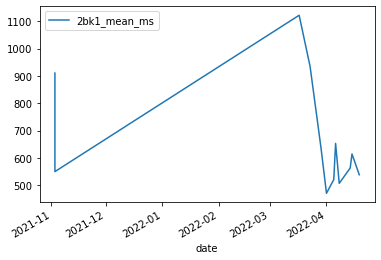

In [7]:
nback_summaries.plot('date', '2bk1_mean_ms')

In [8]:
nback_summaries.columns

Index(['date', '2bk0_mean_ms', '2bk0_median_ms', '2bk0_min_ms', '2bk0_max_ms',
       '2bk0_pct_error', '2bk1_mean_ms', '2bk1_median_ms', '2bk1_min_ms',
       '2bk1_max_ms', '2bk1_pct_error'],
      dtype='object')

<AxesSubplot:xlabel='date'>

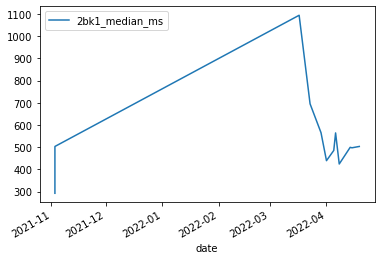

In [9]:
nback_summaries.plot('date', '2bk1_median_ms')

<AxesSubplot:xlabel='date'>

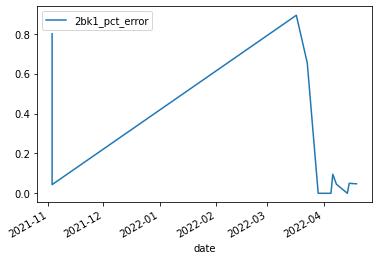

In [10]:
nback_summaries.plot('date', '2bk1_pct_error')

<AxesSubplot:xlabel='date'>

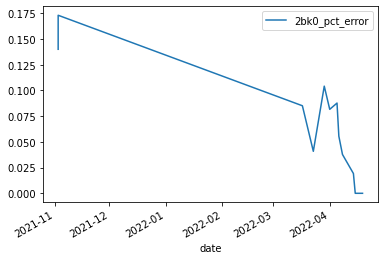

In [11]:
nback_summaries.plot('date', '2bk0_pct_error')

# Run today

In [1]:
today = read_nback_results('/Users/olgabotvinnik/Downloads/N-back.data.2022-04-27--20-01.txt')
today.head()

NameError: name 'read_nback_results' is not defined

In [28]:
today_summary = summarize_nback(today).to_frame().T
today_summary

condition,2bk0_mean_ms,2bk1_mean_ms,2bk0_median_ms,2bk1_median_ms,2bk0_min_ms,2bk1_min_ms,2bk0_max_ms,2bk1_max_ms,2bk0_pct_error,2bk1_pct_error
0,3000.0,548.888889,3000.0,495.5,3000.0,323.0,3000.0,1088.0,0.054545,0.1


In [21]:
today_summary.iloc[0]

condition
2bk0_mean_ms      3000.000000
2bk1_mean_ms       548.888889
2bk0_median_ms    3000.000000
2bk1_median_ms     495.500000
2bk0_min_ms       3000.000000
2bk1_min_ms        323.000000
2bk0_max_ms       3000.000000
2bk1_max_ms       1088.000000
2bk0_pct_error       0.054545
2bk1_pct_error       0.100000
Name: 0, dtype: float64

In [24]:
today_summary.iloc[0].to_clipboard(index=False, name=False)

In [16]:
condition1 = today.query('condition == 1')
100 * condition1.false_alarm.sum()/len(condition1)

4.761904761904762

In [24]:
error_rates = today.groupby("condition").apply(
    lambda x: 100 * x.false_alarm.sum() / len(x)
)
error_rates

condition
0    0.000000
1    4.761905
dtype: float64

In [ ]:
correct = today.query('correct == 1')

In [26]:
correct.groupby(['condition']).milliseconds.mean()

condition
0    3000.00
1     537.75
Name: milliseconds, dtype: float64

In [27]:
correct.groupby(['condition',]).milliseconds.median()

condition
0    3000.0
1     503.0
Name: milliseconds, dtype: float64

In [28]:
correct.groupby(['condition']).milliseconds.min()

condition
0    3000
1     337
Name: milliseconds, dtype: int64

In [29]:
correct.groupby(['condition']).milliseconds.max()

condition
0    3000
1    1034
Name: milliseconds, dtype: int64

# Test Apr1 where error rate should be 8.16%

In [74]:
apr1 = read_nback_results(
    "/Users/olgabotvinnik/Downloads/N-back.datafiles/N-back.data.2022-04-01--20-34.txt"
)

/Users/olgabotvinnik/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [78]:
apr1.condition.value_counts()

0    49
1    26
Name: condition, dtype: int64

In [76]:
apr1.groupby('condition').correct.sum()

condition
0    45
1    26
Name: correct, dtype: int64

In [81]:
100 * (1-apr1.groupby('condition').correct.sum()/apr1.condition.value_counts())

condition
0    8.163265
1    0.000000
dtype: float64

In [76]:
apr1.groupby('condition').correct.sum()

condition
0    45
1    26
Name: correct, dtype: int64

In [77]:
apr1.groupby('condition').false_alarm.sum()

condition
0    0
1    0
Name: false_alarm, dtype: int64